### How does PDE dynamics change with synthetic timesteps?

In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
hydra.initialize(config_path="cfg_flexible", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=KS_short_27"])

In [3]:

from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm

class Traj_dataset:
    traj_train = None
    traj_valid = None
    traj_test = None

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std

def mean_std_normalize():
    assert Traj_dataset.traj_train is not None
    mean = Traj_dataset.traj_train[:32].mean()
    std = Traj_dataset.traj_train[:32].std()
    print(f'Mean: {mean}, Std: {std}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std

def max_min_normalize():
    assert Traj_dataset.traj_train is not None
    max_val = Traj_dataset.traj_train[:32].max()
    min_val = Traj_dataset.traj_train[:32].min()
    mean = (max_val + min_val) / 2
    std = (max_val - min_val) / 2
    print(f'Max: {max_val}, Min: {min_val}')
    Traj_dataset.mean = mean
    Traj_dataset.std = std




print('Loading training data...')
with h5py.File(cfg.dataset.train_path, 'r') as f:
    Traj_dataset.traj_train = torch.tensor(f['train']['pde'][:1000, :131, 0], dtype=torch.float32)
print('Loading test data...')
with h5py.File(cfg.dataset.test_path, 'r') as f:
    Traj_dataset.traj_test = torch.tensor(f['test']['pde'][:1000, :131, 0], dtype=torch.float32)

# print(Traj_dataset.traj_train.mean(dim=-1))

# if cfg.equation == 'Heat' or cfg.equation == 'KS':
#     max_min_normalize()
# else:
mean_std_normalize()

Loading training data...
Loading test data...
Mean: 9.252796751013648e-09, Std: 1.2729687690734863


Text(0.5, 1.0, 'Example trajectory of KS')

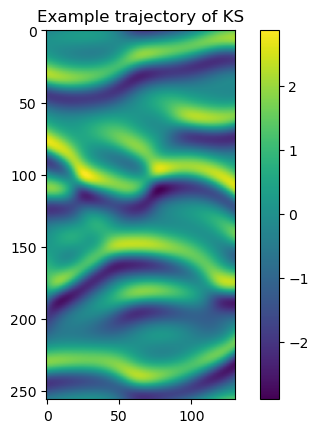

In [4]:
plt.figure()
plt.imshow(Traj_dataset.traj_train[0].cpu().numpy().T)
plt.colorbar()
plt.title(f'Example trajectory of {cfg.equation}')

In [5]:
import h5py
import torch
import numpy as np
from neuralop.models import FNO
from tqdm import tqdm
import random

import argparse
import time

from eval_utils import compute_metrics
from utils import set_seed, flatten_configdict, trajectory_model, direct_model, split_model, normalized_model, zero_mean_model, normalized_residual_model, zero_mean_constant_energy_model

unrolling = cfg.train.unrolling
nt = cfg.nt
ensemble_size = 1
num_acquire = cfg.num_acquire
device = cfg.device
epochs = cfg.train.epochs
lr = cfg.train.lr
batch_size = cfg.train.batch_size
initial_datasize = cfg.initial_datasize

def train(Y, train_nts, **kwargs):
    model = FNO(n_modes=tuple(cfg.model.n_modes), hidden_channels=64,
                in_channels=1, out_channels=1)
    model = model.to(device)
    # model = zero_mean_model(normalized_model(model, Traj_dataset.mean, Traj_dataset.std, Traj_dataset.mean, Traj_dataset.std))
    # model = zero_mean_model(normalized_residual_model(model, Traj_dataset.mean, Traj_dataset.std))
    # model = zero_mean_model(model)
    # model = zero_mean_constant_energy_model(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.MSELoss()

    inputs = []
    outputs = []
    for b in range(Y.shape[0]):
        for t in range(train_nts[b].item()-1):
            inputs.append(Y[b,t])
            outputs.append(Y[b, t+1])
    inputs = torch.stack(inputs, dim=0).unsqueeze(1)
    outputs = torch.stack(outputs, dim=0).unsqueeze(1)

    dataset = torch.utils.data.TensorDataset(inputs, outputs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(epochs)):
        model.train()
        # max_unrolling = epoch if epoch <= unrolling else unrolling
        # unrolling_list = [r for r in range(max_unrolling + 1)]

        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)

            # loss = torch.sqrt(loss)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        # wandb.log({f'train/loss_{acquire_step}': total_loss})
    return model

datasize=32
timestep = (Traj_dataset.traj_train.shape[1] - 1) // (nt - 1) # 10
Y = Traj_dataset.traj_train[:,0::timestep]
train_nts = torch.zeros(Y.shape[0], device=device).int()
train_nts[:datasize] = nt
# model = train(Y, train_nts)
ensemble = [train(Y, train_nts) for _ in range(ensemble_size)]

100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


In [6]:
from generate_data import evolve
from utils import split_model, torch_expand

for model in ensemble:
    model.eval()

X = Y[256:, 0:1]
# with torch.no_grad():

#     preds = [torch_expand(X[:,None], 1, len(ensemble))] # [datasize, ensemble_size, 1, nx]
#     for t in range(nt-1):
#         X_t = preds[-1].clone()
#         X_t = torch.stack([split_model(model, cfg.eval_batch_size)(X_t[:, i].to(device)).cpu() for i, model in enumerate(ensemble)], dim=1) # [datasize, ensemble_size, 1, nx] 
#         preds.append(X_t)
#     mean = torch.cat(preds, dim=2).mean(dim=1) # [datasize, nt, nx]
#     # variance = torch.cat(preds, dim=2).var(dim=1) # [datasize, nt, nx]
#     # variance_per_data = variance.mean(dim=(1,2)) # [datasize]
#     # norm_per_data = torch.norm(mean, dim=(1,2)) # [datasize]
#     # rel = variance_per_data / norm_per_data # [datasize]
#     # ready = rel < 0.2 # [datasize]
#     ready = torch.max(mean, dim=2).values.max(dim=1).values.abs() < 4
#     print(f'Ready: {ready.sum().item()} out of {X.shape[0]}')

ready = torch.ones(X.shape[0]).bool()

traj_ensemble = []
for i in range(ensemble_size):
    with torch.no_grad():
        model = ensemble[i]
        X_t = X[ready]
        X_t = X_t.to(device)
        norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
        # print(x.max())
        traj = [X_t]
        for t in range(nt-1):
            # if t%15 == 0:
            if False:
                x = evolve(x, cfg).to(device)
            else:
                prev_norm = X_t.norm(dim=tuple(range(2, X_t.dim())), keepdim=True)
                X_t = split_model(model, 256)(X_t)
                # x = x / x.norm(dim=tuple(range(2, x.dim())), keepdim=True) * prev_norm
            norms=X_t.norm(dim=tuple(range(2, X_t.dim())))
            # print(x.max())
            traj.append(X_t)
    traj_ensemble.append(torch.cat(traj, dim=1))
traj_ensemble = torch.stack(traj_ensemble, dim=0).mean(dim=0)



In [7]:
traj_ensemble.shape

torch.Size([744, 27, 256])

In [8]:
real_traj = Y[256:][ready, :traj_ensemble.shape[1]]
print(traj_ensemble.shape, real_traj.shape)
assert real_traj.shape == traj_ensemble.shape

print('Computing metrics...')
metrics = compute_metrics(real_traj.flatten(1), traj_ensemble.flatten(1))
print(metrics[0].mean())
print(metrics[1].mean())
print(metrics[2].mean())

torch.Size([744, 27, 256]) torch.Size([744, 27, 256])
Computing metrics...
tensor(0.4673, device='cuda:0')
tensor(0.3670, device='cuda:0')
tensor(0.2419, device='cuda:0')


In [9]:
real_traj.shape

torch.Size([744, 27, 256])

In [10]:
rmse_total = 0
for idx in range(64, 256):
    rmse = torch.sqrt(compute_metrics(real_traj[idx].flatten()[None], traj_ensemble[idx].flatten()[None])[0])
    rmse_total += rmse
    if rmse > 0.9 and rmse < 1.1:
        print(f'idx: {idx}, rmse: {rmse}')
rmse_total /= 192
print(rmse_total)

idx: 67, rmse: tensor([0.9179], device='cuda:0')
idx: 70, rmse: tensor([1.0536], device='cuda:0')
idx: 79, rmse: tensor([0.9872], device='cuda:0')
idx: 84, rmse: tensor([0.9407], device='cuda:0')
idx: 85, rmse: tensor([1.0147], device='cuda:0')
idx: 87, rmse: tensor([1.0189], device='cuda:0')
idx: 104, rmse: tensor([0.9621], device='cuda:0')
idx: 109, rmse: tensor([0.9911], device='cuda:0')
idx: 150, rmse: tensor([0.9827], device='cuda:0')
idx: 160, rmse: tensor([1.0582], device='cuda:0')
idx: 168, rmse: tensor([0.9123], device='cuda:0')
idx: 180, rmse: tensor([0.9103], device='cuda:0')
idx: 181, rmse: tensor([0.9886], device='cuda:0')
idx: 182, rmse: tensor([0.9319], device='cuda:0')
idx: 183, rmse: tensor([0.9471], device='cuda:0')
idx: 212, rmse: tensor([1.0979], device='cuda:0')
idx: 213, rmse: tensor([0.9348], device='cuda:0')
idx: 235, rmse: tensor([0.9548], device='cuda:0')
idx: 254, rmse: tensor([1.0389], device='cuda:0')
tensor([0.6346], device='cuda:0')


Text(0.5, 1.0, 'Difference')

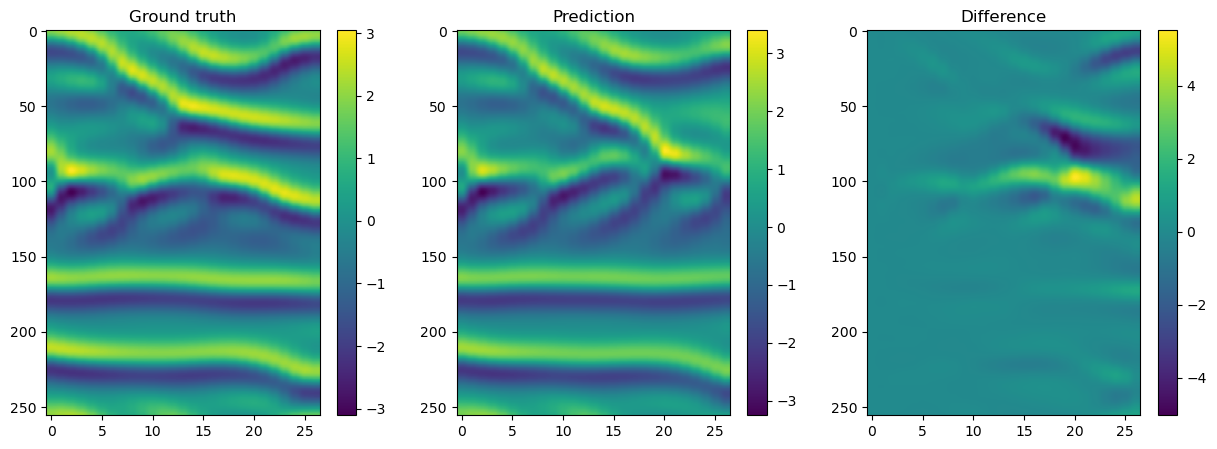

In [27]:
idx = 67
plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(real_traj[idx].cpu().numpy().T, aspect='auto')
plt.colorbar()
plt.title('Ground truth')

plt.subplot(1, 3, 2)
plt.imshow(traj_ensemble[idx].cpu().numpy().T, aspect='auto')
plt.colorbar()
plt.title('Prediction')

plt.subplot(1, 3, 3)
plt.imshow(real_traj[idx].cpu().numpy().T-traj_ensemble[idx].cpu().numpy().T, aspect='auto')
plt.colorbar()
plt.title('Difference')